# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [968]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures

## Read data 

In [969]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

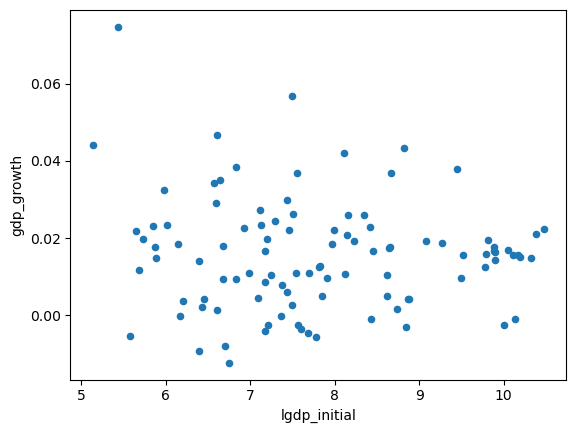

In [970]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

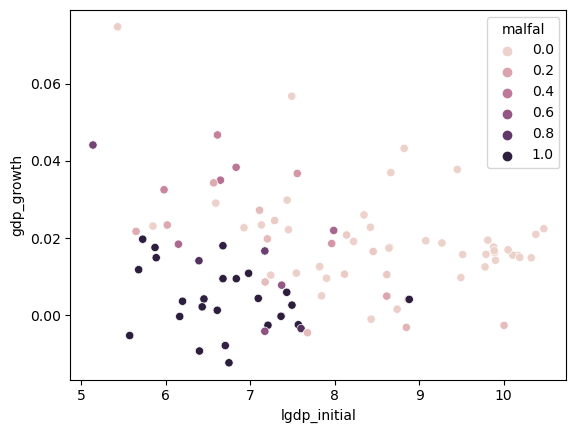

In [971]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [972]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [973]:
dat.isnull().sum() # check for missing values

code                 0
marketref           78
dem                 59
demCGV              64
demBMR              60
                  ... 
investment_rate     35
gdp_growth         112
pop_growth          16
lgdp_initial       105
lpop_initial        15
Length: 85, dtype: int64

# Prepare data

In [974]:
vs = vv_all['geography']
xs = ['pop_growth', 'investment_rate', 'dem'] + vs

# avoiding missings
all_vars = ['gdp_growth', 'lgdp_initial'] + xs
I = dat[all_vars].notnull().all(axis=1)

# extract data
Z_basic = dat.loc[I, xs].values
D = dat.loc[I, 'lgdp_initial']
y = dat.loc[I,'gdp_growth'] * 100. #easier to read output when growth is in 100%

In [975]:
# Add polynomial features. We add interaction terms and quadratic terms
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
Z = poly.fit_transform(Z_basic)

# Calculate variance for each new term
interaction_variances = np.var(Z, axis=0)

# Filter out interaction terms with zero variance
Z = Z[:, interaction_variances > 0]

X = np.column_stack((D,Z))

# Display number of regressors
print("The number of regressors in X is {}".format(X.shape[1]))
print("We are left with observations of {} countries".format(X.shape[0]))

The number of regressors in X is 318
We are left with observations of 84 countries


In [976]:
# Create a function for standardizing
def standardize(X):
    X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X_stan

# Standardize data
X_stan = standardize(X)
Z_stan = standardize(Z)
D_stan = standardize(D)

n,p = X_stan.shape

### Penalities

#### BCCH

In [977]:
# BCCH penalty:
def BCCH(X_stan,y):
    n,p = X_stan.shape
    c = 1.1
    alpha = 0.05
    yXscale = (np.max((X_stan.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale

    # Pilot estimates
    pred = Lasso(alpha=penalty_pilot).fit(X_stan,y).predict(X_stan)

    # Updated penalty
    eps = y - pred 
    epsXscale = (np.max((X_stan.T ** 2) @ (eps ** 2) / n)) ** 0.5
    penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)

    return penalty_BCCH


#### CV

In [978]:
# CV penalty:
def CV(X_stan,y):
    fit_CV = LassoCV(cv=5).fit(X_stan,y)

    # Investigate the penalty
    penalty_CV = fit_CV.alpha_

    return penalty_CV

## POST DOUBLE LASSO

### PDL BCCH penalty

Step 1: Lasso Y using D and Z 

In [979]:
# Calculate BRT
penalty_BCCHyx = BCCH(X_stan, y)
print("lambda_BCCHyx =",penalty_BCCHyx.round(2))

# Run Lasso 
fit_BCCHyx = Lasso(penalty_BCCHyx, max_iter=10000).fit(X_stan, y)
coefs=fit_BCCHyx.coef_

# Calculate residuals
resyx = y-fit_BCCHyx.predict(X_stan)

# Calculate Y - Z@gamma (epsilon + alpha*d)
# Hint: You only need the variables given to you in this cell, in addition
# to a standardized data set you made previoously.
resyxz = resyx + D_stan*coefs[0]

lambda_BCCHyx = 2.42


Step 2: Lasso D using Z

In [980]:
penalty_BCCHdz = BCCH(Z_stan, D)
print("lambda_BCCHdz =",penalty_BCCHdz.round(2))

# Run Lasso
fit_BCCHdz = Lasso(penalty_BCCHdz, max_iter=10000).fit(Z_stan, D)
coefs=fit_BCCHdz.coef_

# Calculate residuals
resdz=D-fit_BCCHdz.predict(Z_stan)

lambda_BCCHdz = 1.09


Step 3: Estimate alpha

In [981]:
# Calculate alpha
num = resdz@resyxz
denom = resdz@D
alpha_PDL = num/denom

# Display alpha
print("alpha_PDL = ",alpha_PDL.round(3))

# Count non-zero coefficients
print("The number of non-zero coefficients in the second stage is =", np.count_nonzero(coefs))

alpha_PDL =  -0.127
The number of non-zero coefficients in the second stage is = 0


Calculate the implied variance estimate, $\check{\sigma}^2$, and calculate the standard deviation of $\check{\alpha}$.

In [982]:
# Calculate the implied variance    
num = resdz**2@resyx**2/n
denom = (resdz.T@resdz/n)**2
sigma2_PDL = num/denom

# Display variance
print("sigma2_PDL = ",sigma2_PDL.round(3))

sigma2_PDL =  1.32


In [983]:
# Calculate standard error
se_PDL = np.sqrt(sigma2_PDL/n)

# Display standard error
print("se_PDL = ",se_PDL.round(3))

se_PDL =  0.125


In [984]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = alpha_PDL - q * se_PDL
CI_high_PDL = alpha_PDL + q * se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(2),CI_high_PDL.round(3)))

CI_PDL =  (-0.37, 0.119)


### PDL CV Penalty

In [985]:
# Calculate CV penalty
penalty_CVyx = CV(X_stan, y)

# Run Lasso 
fit_CVyx = Lasso(penalty_CVyx, max_iter=10000).fit(X_stan, y)
coefs=fit_CVyx.coef_

# Calculate residuals
resyx = y-fit_CVyx.predict(X_stan)

# Calculate Y - Z@gamma (epsilon + alpha*d)
# Hint: You only need the variables given to you in this cell, in addition
# to a standardized data set you made previoously.
resyxz = resyx + D_stan*coefs[0]

/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e-02, tolerance: 1.153e-02
  model = cd_fast.enet_coordinate_descent(
/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.361e-02, tolerance: 1.153e-02
  model = cd_fast.enet_coordinate_descent(
/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Step 2: Lasso D using Z

In [986]:
penalty_CVdz = CV(Z_stan, D)
print("lambda_CVdz =",penalty_CVdz.round(2))

# Run Lasso
fit_CVdz = Lasso(penalty_CVdz, max_iter=10000).fit(Z_stan, D)
coefs=fit_CVdz.coef_

# Calculate residuals
resdz=D-fit_CVdz.predict(Z_stan)

# Display first coefficient
print("First coefficient =",coefs[0].round(5))

/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.573e-02, tolerance: 1.231e-02
  model = cd_fast.enet_coordinate_descent(
/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e-02, tolerance: 1.231e-02
  model = cd_fast.enet_coordinate_descent(
/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

lambda_CVdz = 0.04
First coefficient = -0.0


Step 3: Estimate alpha

In [987]:
# Calculate alpha
num = resdz@resyxz
denom = resdz@D
alpha_PDL = num/denom

# Display alpha
print("alpha_PDL = ",alpha_PDL.round(3))

# Count non-zero coefficients
print("The number of non-zero coefficients in the second stage is =", np.count_nonzero(coefs))

alpha_PDL =  -0.735
The number of non-zero coefficients in the second stage is = 31


Calculate the implied variance estimate, $\check{\sigma}^2$, and calculate the standard deviation of $\check{\alpha}$.

In [988]:
# Calculate variance    
num = resdz**2@resyx**2/n
denom = (resdz.T@resdz/n)**2
sigma2_PDL = num/denom

# Display variance
print("sigma2_PDL = ",sigma2_PDL.round(3))

sigma2_PDL =  4.71


In [989]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = alpha_PDL - q * se_PDL
CI_high_PDL = alpha_PDL + q * se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(2),CI_high_PDL.round(3)))

CI_PDL =  (-0.98, -0.49)
